In [1]:
import librosa
import numpy as np
import pandas as pd
from IPython.display import Audio
import os
import shutil
import skimage
import skimage.io
from PIL import Image


class Preprocess:
    def __init__(self, hop_length=256, n_mels=80, win_size=128):
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.n_fft = hop_length * 4
        self.frame_length = hop_length * 4
        self.win_size= win_size
        
    def scale_minmax(self, X, min=0, max=255):
        '''
        Scales and converts the spectrogram to a PNG
        Called by spectrogram_image()
        '''
        X_std = (X - X.min()) / (X.max() - X.min())
        X_scaled = X_std * (max - min) + min
        return X_scaled
    
    def loudest_window(self, spectrogram):
        '''
        Identifies the loudest window of a specified size within a spectrogram
        '''
        # Convert the array to a spectrogram
        array = np.asarray(spectrogram)
        # get the width of the array
        width = array.shape[1]
        # set the starting and ending of the window
        start = 0
        end = self.win_size
        arrays = []
        # move the window across the image advancing by 1 pixel.
        # append the array in the window to the list of arrays
        while end <= width:
            window = array[0:self.n_mels,start:end]
            arrays.append(window)
            start += 1
            end += 1
        # get the sum of each window in the array
        sums = [np.sum(window) for window in arrays]
        # get the index of the smallest window. This will be the loudest section
        index = sums.index(max(sums))
        # pull the loudest window from the list and return it.
        loudest = arrays[index]
        return loudest

    def add_silence(self, spectrogram):
        '''
        Adds silence to the end of a spectrogram if the spectrogram is shorter than
        the minimum window size
        '''
        # get the width of the spectrogram
        width = spectrogram.shape[1]
        # subtract the width from the minimum width to determine number of silent columns to add
        n_col = self.win_size-width
        # create silent columns
        silence = np.full((self.n_mels, n_col), 0)
        # convert the spectrogram to an array
        spect_ar = np.asarray(spectrogram)
        # add the silence to the spectrogram array
        spect_ar = np.concatenate((spect_ar, silence), axis = 1).astype(np.uint8)
        return spect_ar

    def standardize(self, spectrogram):
        '''
        Standardizes an image using the loudest_window() and add_silence() functions
        Pass spectrogram as an array
        '''
        width = spectrogram.shape[1]
        # if the width of the spectrogram is less than the minimum, add silence
        if width < self.win_size:
            spect = self.add_silence(spectrogram)
        # otherwise get the loudest window
        else:
            spect = self.loudest_window(spectrogram)
        # scale and return
        return scale_minmax(spect).astype(np.uint8)
    
    def spectrogram_image(self, wav_file, out_file = '', save = True):
        '''
        Converts a WAV file to a spectrogram and sames the image

        wav_file: The path to a WAV file as a string
        '''
        # load the audio data
        y, sr = librosa.load(wav_file)
        # trim the silence at edges
        #sample, _ = librosa.effects.trim(y, top_db=30, ref = np.max, hop_length = 128, frame_length=512)
        # use log-melspectrogram
        mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels,
                                                n_fft=self.hop_length*4, hop_length=self.hop_length)
        # convert mel to decibles
        DB = librosa.power_to_db(mels, ref=np.max)
        # Standardize by finding the loudest window or adding silence
        # and rescaling
        DB = self.standardize(DB)

        # save the image
        if save == True:
            skimage.io.imsave(out_file, DB)
        else:
            return Image.fromarray(DB, mode = 'P')
        
    def play_spectrogram(self, spectrogram, sr = 22050, n_fft = 1024, hop_length = 256):
        array = np.asarray(spectrogram)
        mels = librosa.db_to_power(array, ref=1)
        return Audio(librosa.feature.inverse.mel_to_audio(mels, sr = sr, n_fft = self.hop_length*4, hop_length = self.hop_length), rate = sr)

In [20]:
# initialize
dir = '/home/mike/Insync/OneDrive/Emotions/project/results2/images/'
prep = Preprocess()

In [25]:
# import spectrograms()
fake = Image.open(dir + '1011_ITH_fake_B.png').convert('L')
reala = Image.open(dir + '1011_ITH_real_A.png').convert('L')
realb = Image.open(dir + '1011_ITH_real_B.png').convert('L')

In [24]:
# play
prep.play_spectrogram(realb, hop_length = 128)

# Testing

In [33]:
from skimage import color
from skimage import io

img = color.rgb2gray(io.imread(dir + '03-01-01-01-01_real_A.png'))

In [46]:
skimage.io.imsave('test.png', np.asarray(reala))
im = Image.open('test.png')

In [66]:
np.asarray(im.convert('L'))

array([[224, 217, 233, ..., 255, 255, 255],
       [192, 183, 201, ..., 255, 255, 255],
       [178, 169, 187, ..., 255, 255, 255],
       ...,
       [196, 183, 184, ..., 255, 255, 255],
       [186, 178, 175, ..., 255, 255, 255],
       [196, 188, 185, ..., 255, 255, 255]], dtype=uint8)

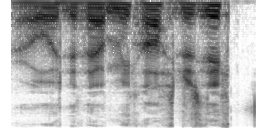

In [73]:
reala.rotate(180)

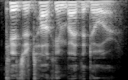

In [68]:
og = Image.open('/home/mike/Insync/OneDrive/Emotions/project/git_repository/spectrograms/neutral/03-01-01-01-01.png')
og